## Train, Optimize, Evaluate and Explain a Tumor/Normal Classifier

Train a neural network on TCGA+TARGET+GTEX gene expression to classify tumor vs. normal.

Optimize the model using [Hyperband](http://fastml.com/tuning-hyperparams-fast-with-hyperband/)

Evalute the model and explain using [SHapley Additive exPlanations](https://github.com/slundberg/shap) and [Dropout based uncertainty measurement](https://hjweide.github.io/quantifying-uncertainty-in-neural-networks)

In [23]:
import os
import json
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

# fix random seed for reproducibility
np.random.seed(42)

# Load and Wrangle Data

In [24]:
%%time
X = pd.read_hdf("data/tcga_target_gtex.h5", "expression")
Y = pd.read_hdf("data/tcga_target_gtex.h5", "labels")

CPU times: user 187 ms, sys: 2.55 s, total: 2.74 s
Wall time: 2.74 s


In [25]:
# Prune X to only KEGG pathway genes
# with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
#     genes_subset = list(set().union(*[line.strip().split("\t")[2:] for line in f.readlines()]))
    
# Prune X to only Cosmic Cancer Genes
genes_subset = pd.read_csv("data/cosmic_germline.tsv", sep="\t")["Gene Symbol"].values
X_pruned = X.drop(labels=(set(X.columns) - set(genes_subset)), axis=1, errors="ignore")

# order must match dataframe
genes = list(X_pruned.columns.values)
print("Pruned expression to only include", len(genes), "genes")

# Create a one-hot for tumor/normal training and numeric disease label for stratification
from sklearn.preprocessing import LabelEncoder
tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index)

disease_encoder = LabelEncoder()
Y["disease_value"] = pd.Series(disease_encoder.fit_transform(Y["disease"]), index=Y.index)

Pruned expression to only include 102 genes


In [26]:
# Divide into training and test sets strattified by disease
# Split into stratified training and test sets based primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X.values, Y.disease):
    X_train = X_pruned.values[train_index]
    X_test = X_pruned.values[test_index]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]

print(X_train.shape, X_test.shape)

(15300, 102) (3826, 102)


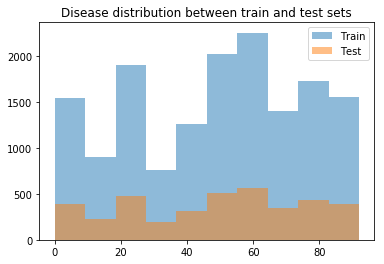

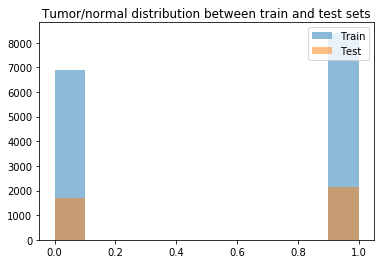

In [27]:
# Lets see how big each class is based on primary site
plt.hist(Y_train.disease_value.values, alpha=0.5, label='Train')
plt.hist(Y_test.disease_value.values, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Disease distribution between train and test sets")
plt.show()

# Lets see how big each class is based on primary site
plt.hist(Y_train.tumor_normal_value.values, alpha=0.5, label='Train')
plt.hist(Y_test.tumor_normal_value.values, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Tumor/normal distribution between train and test sets")
plt.show()

# Build and Train Model

In [28]:
%%time
from keras.models import Model
from keras.layers import Input, BatchNormalization, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

def create_model(input_shape, output_shape, params):
    inputs = Input(shape=(input_shape,))

    x = BatchNormalization()(inputs)

    x = Dense(16, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(output_shape, kernel_initializer="normal", activation="sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model = create_model(X_train.shape[1], 1, {})
model.summary()

callbacks = [EarlyStopping(monitor="acc", min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, Y_train.tumor_normal_value.values, epochs=10, batch_size=128, shuffle="batch", callbacks=callbacks)
print(model.metrics_names, model.evaluate(X_test, Y_test.tumor_normal_value.values))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 102)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 102)               408       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1648      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total para

In [29]:
# Save the model to disk so we can read and predict without training

# See https://github.com/h5py/h5py/issues/712
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" 

with open("models/disease.params.json", "w") as f:
    f.write(json.dumps({
        "tumor_normal": tumor_normal_encoder.classes_.tolist(),
        "diseases": disease_encoder.classes_.tolist(),
        "genes": genes}))

with open("models/disease.model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("models/disease.weights.h5")

In [30]:
# Load the model and predict the test set so we're using exactly what we'll load later from disk
model = keras.models.model_from_json(open("models/disease.model.json").read())
model.load_weights("models/disease.weights.h5")
params = json.loads(open("models/disease.params.json").read())

## Explore Shapely for Gene Biomarker Identification

Evaluate several tissues to see if Shapely values re-capitulate any known biomarkers

In [31]:
import shap

# import warnings; warnings.simplefilter('ignore')

def shap_predict(X):
    return model.predict(X).flatten()

shap.initjs() 

## Explain Breast Predictions

In [32]:
# Select tumor and normal samples from a single tissue as background
X_tumor = X_pruned.loc[Y[Y.disease == "Breast Invasive Carcinoma"].index]
X_normal = X_pruned.loc[Y[Y.disease == "Breast - Mammary Tissue"].index]
print("Found {} tumor and {} normal samples".format(X_tumor.shape[0], X_normal.shape[0]))

background_samples = pd.concat([X_tumor.iloc[:25], X_normal.iloc[:25]])
print("Explantion based on {} samples".format(background_samples.shape[0]))

explainer = shap.KernelExplainer(shap_predict, background_samples)

Found 1212 tumor and 179 normal samples
Explantion based on 50 samples


/opt/conda/lib/python3.6/site-packages/iml/datatypes.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return DenseData(val.as_matrix(), list(val.columns))


In [33]:
# Show details for a tumor sample
np.random.seed(42)
sample_shap_values = explainer.shap_values(X_tumor.iloc[10], nsamples=150)
shap.force_plot(sample_shap_values, X_tumor.iloc[10])

In [34]:
# Show details for a normal sample
np.random.seed(42)
sample_shap_values = explainer.shap_values(X_normal.iloc[0], nsamples=150)
shap.force_plot(sample_shap_values, X_normal.iloc[0])

In [35]:
# Explain a subset of tumor and normal samples
background_shap_values = explainer.shap_values(background_samples, nsamples=150)

100%|██████████| 50/50 [01:58<00:00,  2.36s/it]


In [36]:
shap.force_plot(background_shap_values, background_samples)